# Inference: Adaptive Covariance MCMC

This example shows you how to perform Bayesian inference on a time series, using an adaptive MCMC method.

Running...
Done!


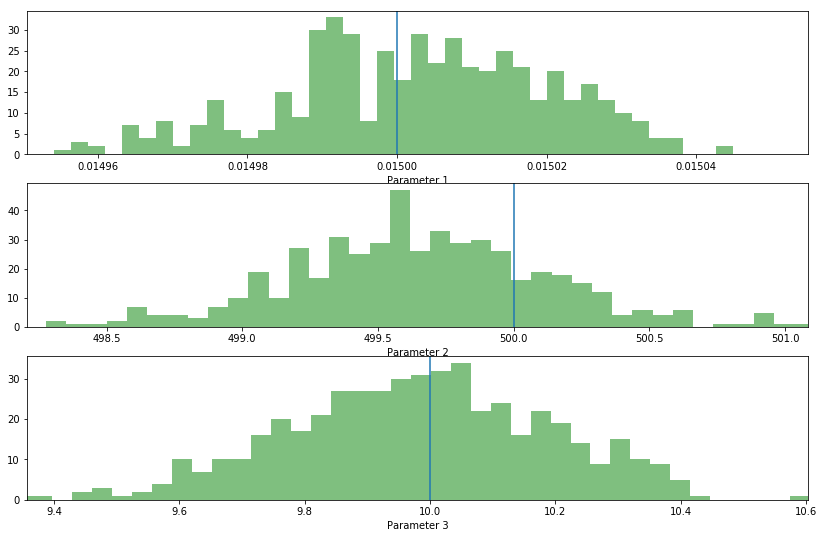

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_likelihood = pints.LogPosterior(prior, log_likelihood)

# Create an adaptive covariance MCMC routine
x0 = real_parameters * 1.1
mcmc = pints.AdaptiveCovarianceMCMC(log_likelihood, x0)

# Aim for an acceptance rate of 0.3
mcmc.set_acceptance_rate(0.3)

# Use 4000 iterations in total
mcmc.set_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_non_adaptive_iterations(1000)

# Discard the first 2000 iterations as burn in
mcmc.set_burn_in(2000)

# Store only every 4th sample
mcmc.set_thinning_rate(4)

# Disable verbose mode
mcmc.set_verbose(False)

# Run!
print('Running...')
chain = mcmc.run()
print('Done!')

# Plot output
pl.figure(figsize=(14, 9))
for i, real in enumerate(real_parameters):
    
    # Add subplot
    pl.subplot(len(real_parameters), 1, 1+i)
    pl.xlabel('Parameter ' + str(i + 1))
    
    # Show true value
    pl.axvline(real)
    
    # Show histogram of chain
    pl.hist(chain[:,i], label='p' + str(i + 1), bins=40, color='green',
        alpha=0.5)
    
    # Center plot around mean of chain
    mu = np.mean(chain[:,i])
    sigma = np.std(chain[:,i])
    pl.xlim(mu - 3 * sigma, mu + 3 * sigma)

pl.show()